In [53]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
from tqdm import tqdm

import jax
import jax.numpy as jnp
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../plotting/matplotlibrc')

In [ ]:
from accretion import *

# BHL and PR accretion

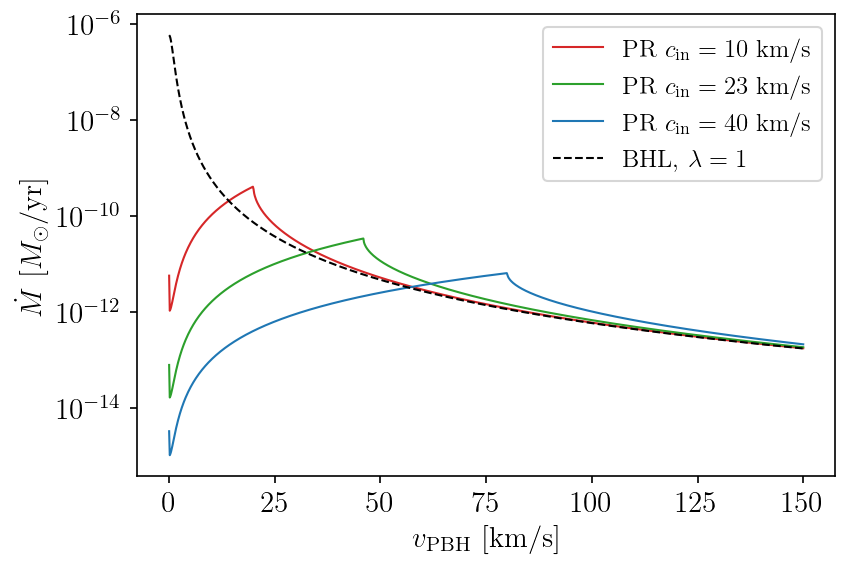

In [4]:
rho_inf = c.m_p.to(u.g).value * 1e3 # [g/cm^3]
c_inf = 1 # [km/s]
c_in = 23 # [km/s]
M = 10 # [M_sun]
v_arr = np.linspace(0.01, 150, 1000) # [km/s]
Mdot_PR10_arr = np.array([Mdot_PR(M, rho_inf, v, 10, c_inf) for v in v_arr])
Mdot_PR23_arr = np.array([Mdot_PR(M, rho_inf, v, 23, c_inf) for v in v_arr])
Mdot_PR40_arr = np.array([Mdot_PR(M, rho_inf, v, 40, c_inf) for v in v_arr])
Mdot_BHL_arr = np.array([Mdot_BHL(M, rho_inf, v, None, c_inf) for v in v_arr])

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.plot(v_arr, Mdot_PR10_arr, label=r'PR $c_\mathrm{in}=10$ km/s', lw=1)
axs.plot(v_arr, Mdot_PR23_arr, label=r'PR $c_\mathrm{in}=23$ km/s', lw=1)
axs.plot(v_arr, Mdot_PR40_arr, label=r'PR $c_\mathrm{in}=40$ km/s', lw=1)
axs.plot(v_arr, Mdot_BHL_arr, 'k--', label=r'BHL, $\lambda=1$', lw=1)
axs.set(yscale='log')
axs.set(xlabel=r'$v_\mathrm{PBH}$ [km/s]', ylabel=r'$\dot{M}$ [$M_\odot$/yr]')
axs.legend()
fig.savefig('Mdot_PR_BHL.pdf', bbox_inches='tight')

# Cosmological PBH: injected energy vs. redshift

In [ ]:
from astropy.cosmology import Planck18 as cosmo
sys.path.append(os.environ['DH_DIR'])
from darkhistory import physics as phys

$$f(v)dv=\left(\frac{m}{2\pi kT}\right)^{3/2} 4\pi v^2 \exp\left[-\frac{mv^2}{2kT}\right]dv=\left(\frac{3}{2\pi v_\text{rms}^2}\right)^{3/2} 4\pi v^2 \exp\left[-\frac{3v^2}{2v_\text{rms}^2}\right]dv, \qquad v_\text{rms}^2 = \frac{3kT}{m}$$

In [75]:
z_arr = np.linspace(5, 1000, 100)

M_PBH = 100 # [M_sun]
f_PBH = 1.
c_in = 23 # [km/s]

@jax.jit
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def Mdot_BHL_cosmo(v, M_PBH, rho_inf, c_in, c_inf):
    return Mdot_BHL(M_PBH, rho_inf, v, c_in, c_inf) # [M_sun/yr]

@jax.jit
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def Mdot_PR_cosmo(v, M_PBH, rho_inf, c_in, c_inf):
    return Mdot_PR(M_PBH, rho_inf, v, c_in, c_inf) # [M_sun/yr]

@jax.jit
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def L_ADAF_BHL_cosmo(v, M_PBH, rho_inf, c_in, c_inf):
    Mdot = Mdot_BHL(M_PBH, rho_inf, v, c_in, c_inf) # [M_sun/yr]
    return L_ADAF(Mdot, M_PBH)

@jax.jit
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def L_ADAF_PR_cosmo(v, M_PBH, rho_inf, c_in, c_inf):
    Mdot = Mdot_PR(M_PBH, rho_inf, v, c_in, c_inf) # [M_sun/yr]
    return L_ADAF(Mdot, M_PBH)

Mdot_BHL_arr = []
Mdot_PR_arr = []
L_BHL_arr = []
L_PR_arr = []

for i, z in enumerate(tqdm(z_arr)):

    n_PBH = f_PBH * (cosmo.critical_density(z) * cosmo.Odm(z) / (M_PBH * u.M_sun)).to(u.cm**-3).value # [cm^-3]
    rho_inf = (cosmo.critical_density(z) * cosmo.Ob(z)).to(u.g/u.cm**3).value # [g/cm^3]
    T_K = phys.Tm_std(1+z) # [eV]
    c_inf = np.sqrt(5/3 * T_K * u.eV / c.m_p).to(u.km/u.s).value # [km/s]
    v_cb = v_cb_cosmo(z) # [km/s]

    v_max = 10 * v_cb
    v_min = v_cb / 10
    v_s = jnp.linspace(v_min, v_max, 1000)
    f_s = f_MB(v_s, v_cb)

    Mdot_BHL_s = Mdot_BHL_cosmo(v_s, M_PBH, rho_inf, c_in, c_inf)
    Mdot_PR_s = Mdot_PR_cosmo(v_s, M_PBH, rho_inf, c_in, c_inf)
    
    L_BHL_s = L_ADAF_BHL_cosmo(v_s, M_PBH, rho_inf, c_in, c_inf)
    L_PR_s = L_ADAF_PR_cosmo(v_s, M_PBH, rho_inf, c_in, c_inf)

    Mdot_BHL_arr.append(jnp.trapz(Mdot_BHL_s * f_s, v_s))
    Mdot_PR_arr.append(jnp.trapz(Mdot_PR_s * f_s, v_s))
    L_BHL_arr.append(jnp.trapz(L_BHL_s * f_s, v_s))
    L_PR_arr.append(jnp.trapz(L_PR_s * f_s, v_s))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 158.91it/s]


Text(0.5, 0.98, 'Cosmological contribution')

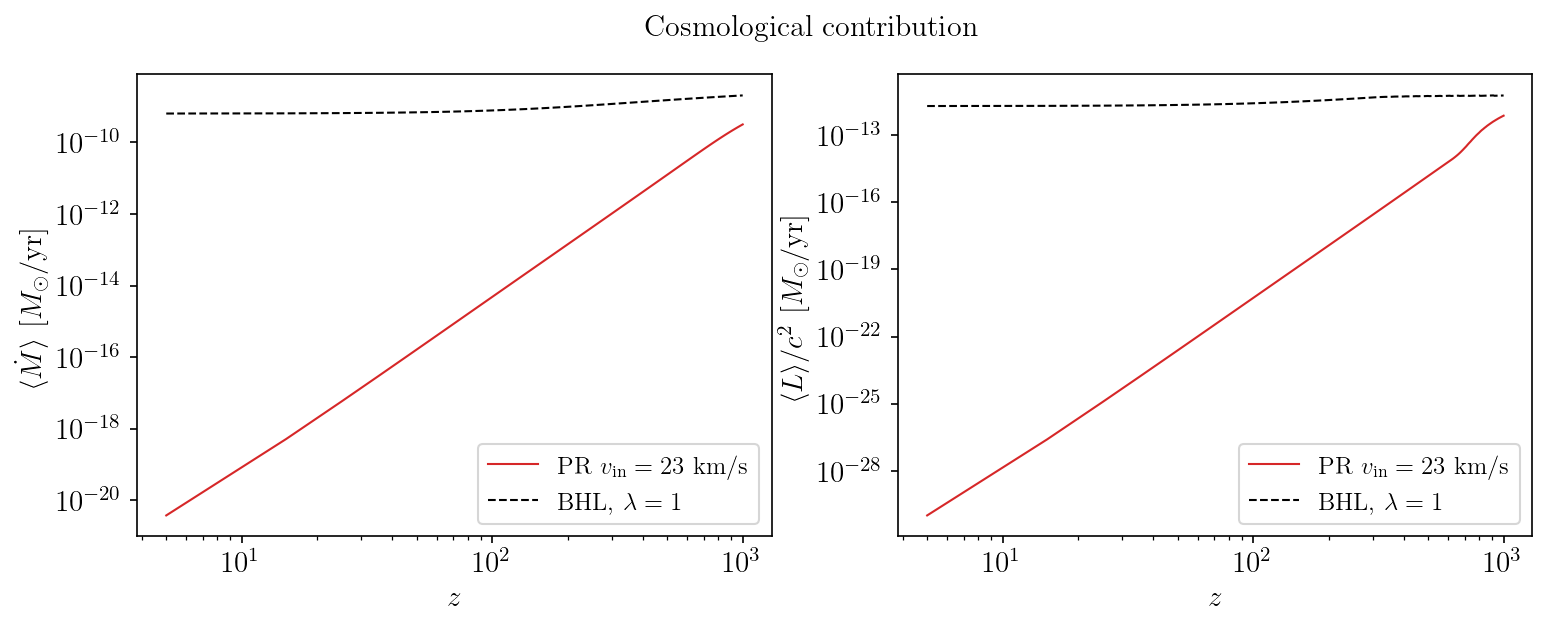

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(z_arr, Mdot_PR_arr, lw=1, label='PR $v_\mathrm{in}=23$ km/s')
axs[0].plot(z_arr, Mdot_BHL_arr, 'k--', lw=1, label='BHL, $\lambda=1$')
axs[0].set(xscale='log', yscale='log')
axs[0].set(xlabel=r'$z$', ylabel=r'$\langle\dot{M}\rangle$ [$M_\odot$/yr]')
axs[0].legend()

axs[1].plot(z_arr, L_PR_arr, lw=1, label='PR $v_\mathrm{in}=23$ km/s')
axs[1].plot(z_arr, L_BHL_arr, 'k--', lw=1, label='BHL, $\lambda=1$')
axs[1].set(xscale='log', yscale='log')
axs[1].set(xlabel=r'$z$', ylabel=r'$\langle L\rangle/c^2$ [$M_\odot$/yr]')
axs[1].legend()

fig.suptitle('Cosmological contribution')

# Halo contribution

$$L_\text{halo}=\int_V n_\text{PBH}L_\text{PBH}=\frac{f}{M_\text{PBH}}\int_0^{r_\Delta}4\pi r^2dr \rho(r)L()$$